In [1]:
import pygrib, time, os, sys, scipy
import numpy as np
import cartopy as ct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from datetime import datetime, timedelta
from matplotlib.collections import LineCollection

In [2]:
# domain with 0.25 deg spacing
lats = np.flip(np.arange(20, 50.25, 0.25))
lons = np.arange(-90, -39.75, 0.25)

# contour levels for wind speeds
wlevels = np.arange(15, 45, 5)

In [3]:
# takes storm tracking dataframe and drops storms that don't reach a min SLP
def SLP_filter(df_out, minSLP):
    df_out = df_out.drop(df_out[df_out['min_p_h (Pa)'] > minSLP].index)
    df_out = df_out.reset_index(drop=True)
    return df_out

In [4]:
# reads CSV file of storm track output into a dataframe
def read_track_csv(year):
    path_base = r"/.../noreasters"
    return pd.read_csv(path_base + '/' + str(year) + '_tracks_final.csv', usecols=np.arange(1, 31))

In [5]:
# combines 2 previous functions; reads CSV files of storm track output while dropping storms that don't reach a min SLP
def read_years_SLP(years, minSLP):
    all_df = []
    for year in years:
        all_df.append(SLP_filter(read_track_csv(year), minSLP))
    return all_df

In [6]:
# converts gridpts to lat/lon coordinates
def lat_lon(gridx, gridy, lons, lats):
    lon = lons[gridx]
    lat = lats[gridy]
    return lon, lat

In [7]:
# given a list of gridpts, convert to lat/lon coordinates
def grids_to_map(xs, ys, lons, lats):
    lons_coords = [lat_lon(x, 0, lons, lats)[0] for x in xs]
    lats_coords = [lat_lon(0, y, lons, lats)[1] for y in ys]
    return lons_coords, lats_coords

In [8]:
# CSV data is in string format
# this function reads the string data into lists of values
def get_list_val_f(df):
    cx_ps = []
    cy_ps = []
    max_ws = []
    lats_s = []
    lons_s = []
    for i in range(len(df)):
        if df['cx_p'][i][-3] != 'f':
            cx_pi = [int(s) for s in df['cx_p'][i][1:-1].split(', ')]
            cy_pi = [int(s) for s in df['cy_p'][i][1:-1].split(', ')]
            max_wi = [float(s) for s in df['max_w_h (m/s)'][i][1:-1].split()][::6]
        else:
            cx_pi = [int(s) for s in df['cx_p'][i][1:].split(', ')[:-1]]
            cy_pi = [int(s) for s in df['cy_p'][i][1:].split(', ')[:-1]]
            max_wi = [float(s) for s in df['max_w_h (m/s)'][i][1:].split()[:-1]][::6]
        cx_ps.append(cx_pi)
        cy_ps.append(cy_pi)
        max_ws.append(max_wi)

        lons_i, lats_i = grids_to_map(cx_pi, cy_pi, lons, lats)
        lons_s.append(lons_i)
        lats_s.append(lats_i)
    return cx_ps, cy_ps, max_ws, lons_s, lats_s

In [9]:
# helper function for turning a line (list of points) into line segments
# ex) [a, b, c, d] into [(a, b), (b, c), (c, d)]
# this is done in order to plot a storm trajectory as a multi-colored line, where color denotes the wind speed
def get_segments(loncs, latcs):
    pairs = np.array(list(zip(loncs, latcs))).reshape(-1, 1, 2)
    return np.hstack([pairs[:-1], pairs[1:]])

In [10]:
# read in storm tracking output, drop storms that don't reach a minimum of 980 hPa
allyrs = np.arange(1940, 2025)
dfs = read_years_SLP(allyrs, 98000)

In [11]:
# read in coordinates and wind speeds for all nor'easters
ws = []
loncs = []
latcs = []
segments_all = []
for dfi in dfs:
    cxs_i, cys_i, ws_i, loncs_i, latcs_i = get_list_val_f(dfi)
    ws.append(ws_i)
    loncs.append(loncs_i)
    latcs.append(latcs_i)
    segments_yr = []
    for i in range(len(ws_i)):
        segments_yr.append(get_segments(loncs_i[i], latcs_i[i]))
    segments_all.append(segments_yr)

In [12]:
# number of nor'easters identified 1940-2025 (<980 hPa)
nlen = 0
for wi in ws:
    nlen += len(wi)
nlen

900

In [13]:
# average number of nor'easters per year
nlen/(allyrs[-1]+1-allyrs[0])

10.588235294117647

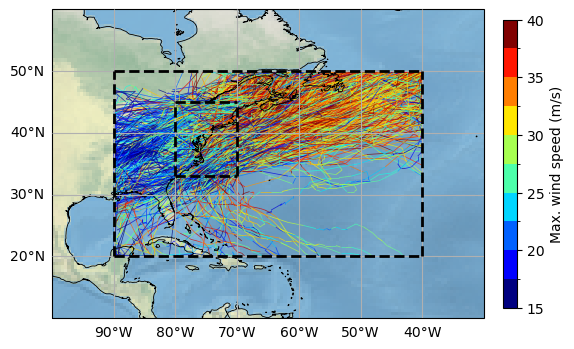

In [14]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ct.crs.PlateCarree())
full_map = [-100, -30, 10, 60]
#full_map = [-90, -40, 20, 50]
#full_map = [-89, -41, 21, 49]
ax.stock_img()
ax.set_extent(full_map, crs=ct.crs.PlateCarree())
ax.coastlines(linewidth=0.6, zorder=10, color='black')
#ax.add_feature(ct.feature.STATES, linewidth=0.6, zorder=11, edgecolor='black')
gls = ax.gridlines(draw_labels=True, zorder=12)
gls.top_labels=False
gls.right_labels=False
wlevels = np.arange(15, 42.5, 2.5)
norm = mpl.colors.BoundaryNorm(wlevels, mpl.cm.jet.N)
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax, orientation='vertical', fraction=0.031, pad=0.04, label='Max. wind speed (m/s)')
for i in range(len(allyrs)):
    for j in range(len(dfs[i])):
        coll = LineCollection(segments_all[i][j], cmap='jet')
        coll.set_array(ws[i][j])
        coll.set_linewidth(0.55)
        coll.set_alpha(0.75)
        ax.add_collection(coll)

# dotted black box for domain that tracking algorithm was applied to
plt.plot([-90, -90], [20, 50], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-40, -40], [20, 50], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-90, -40], [20, 20], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-90, -40], [50, 50], linestyle='--', linewidth=2, color='k', zorder=14)

# dotted black box for US East Coast bounding box
plt.plot([-70, -70], [33, 45], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-80, -80], [33, 45], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-80, -70], [33, 33], linestyle='--', linewidth=2, color='k', zorder=14)
plt.plot([-80, -70], [45, 45], linestyle='--', linewidth=2, color='k', zorder=14)

# # save plot
# plt.savefig('Fig2_spaghetti_plot.pdf', format='pdf', dpi=600, bbox_inches='tight') 